# Report on GMM: Combination of K-Means and EM Algorithms

by Ruijie Rao

In [1]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

# Data Importation

In [2]:
with open("clusters.txt", "r") as file:
    content = file.readlines()

In [3]:
data = np.array([line.strip("\n").split(",") for line in content] ).astype(float)

## Plot the data

Plotting the data tells me and the reader about how the data points are distributed. Obviously, it is hard for human eyes to decide the 3 clusters from this plot.

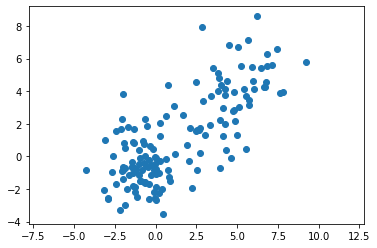

In [4]:
ax = plt.gca()
ax.axis('equal')
ax.scatter(data[:, 0], data[:, 1], cmap='viridis', zorder=2)

# K-Means Algorithm Construct

## Alg Config

In [35]:
k = 3 # number of clusters
rs = np.random.RandomState(2022) # Randomstate 

## Random Initialization

Initialize 3 centroids by Randomly choosing 3 points within range.

In [64]:
x_min = np.min(data[:,0])
x_max = np.max(data[:,0])
centroids = rs.randint(x_min,x_max,size=(3,len(data[0])))

## Update Centroids

In [102]:
assignments = [np.argmin([np.linalg.norm(center-d) for center in centroids]) for d in data]\
# assigning data to closest centroids reguarding distances
centroids = np.array([np.mean([data[j] for j in range(len(data)) if assignments[j]==i],axis=0) for i in range(k)]) \
# Taking the mean of each assigned clusters to update the centroids

## Plot Construct

Clusters will be showed on the graph using different colors, points will only be shown in a single color.

In [150]:
def plot_K_Means(data,centroids,assignments):
    ax = plt.gca()
    ax.axis('equal')
    ax.scatter(data[:, 0], data[:, 1], c=assignments, s=40, cmap='viridis', zorder=2)
    ax.scatter(centroids[:, 0], centroids[:, 1], c="black",marker="x", s=40, cmap='viridis', zorder=2)
    plt.show()

## K_Means Main Construct

In [152]:
def K_Means(data,k,n=20,rs=np.random.RandomState(0)):
    x_min = np.min(data[:,0])
    x_max = np.max(data[:,0])
    centroids = rs.randint(x_min,x_max,size=(3,len(data[0])))
    for c in range(n):
        assignments = [np.argmin([np.linalg.norm(center-d) for center in centroids]) for d in data]\
        # assigning data to closest centroids reguarding distances
        centroids = np.array([np.mean([data[j] for j in range(len(data)) if assignments[j]==i],axis=0) for i in range(k)]) \
        # Taking the mean of each assigned clusters to update the centroids
        if c%5==0 or c==n-1:
            print(f"Iteration: {c}")
            plot_K_Means(data,centroids,assignments)
    return centroids

## Test

Iteration: 0


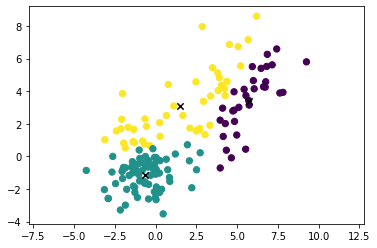

Iteration: 5


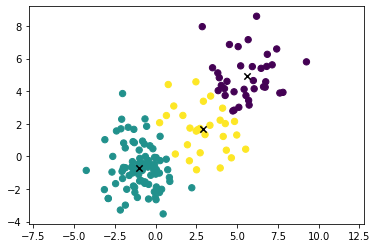

Iteration: 9


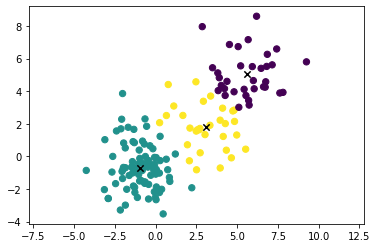

In [153]:
centroids = K_Means(data,k,n=10,rs=np.random.RandomState(2022))

## Result

Result include centroids coordinates:

In [146]:
centroids

array([[ 5.62016573,  5.02622634],
       [-0.97476572, -0.68419304],
       [ 3.08318256,  1.77621374]])

Displaying Clusters and their centroids.

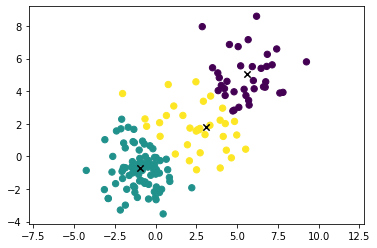

In [147]:
plot_K_Means(data,centroids,assignments)

# GMM Algorithm Construct

## Brief GMM Description

GMM, standing for Gaussian Mixture Model, is a combination of K-Means and EM algorithms which fixes most of the drawbacks (including crossing clusters, surrounded clusters) of K-Means and its sibling clustering algorims. 

The aim of the algorithm is to find a group of best fit Gaussian models or Normal Distribution for the data points.

### Expectation Maximization (EM) Implementation

EM is a algorithm that works when a couple of hard problem appears. If solving each of the problem in the pair makes the other one simple, then EM can be implemented.

The hard problem pair in the GMM situation is:
1. Given Data points X, find partial memberships of each of the points in each of the clusters.
2. Given Data points X, find the mian, std and amplitude of k fitting Gaussian Models.

By using EM Algorithm, we can solve our problems by iterating between E and M 2 steps and the iteration will converge to a optimal solution according to EM.

### E-M Iteration

- E step:
    Given Model Parameters for all k Distributions, find partial memberships for all x.

$$
r_{ic} = \frac{\pi_c N(\boldsymbol{x_i} \ | \ \boldsymbol{\mu_c},\boldsymbol{\Sigma_c})}{\Sigma_{k=1}^K \pi_k N(\boldsymbol{x_i \ | \ \boldsymbol{\mu_k},\boldsymbol{\Sigma_k}})}
$$
- M step:
    Given partial memberships for all x, find Model Parameters for all k Distributions.
    
$$
m_c \ = \ \Sigma_i r_{ic} \\
\pi_c \ = \ \frac{m_c}{m} \\
\boldsymbol{\mu_c} \ = \ \frac{1}{m_c}\Sigma_i r_{ic} \boldsymbol{x_i} \\
\boldsymbol{\Sigma_c} \ = \ \Sigma_i r_{ic}(\boldsymbol{x_i}-\boldsymbol{\mu_c})^T(\boldsymbol{x_i}-\boldsymbol{\mu_c})
$$


## Alg Config

In [5]:
k = 3 # number of clusters
rs = np.random.RandomState(2022) # Randomstate 

## E Step:

I will be constructing this part strictly based on the formula:

$$
r_{ic} = \frac{\pi_c N(\boldsymbol{x_i} \ | \ \boldsymbol{\mu_c},\boldsymbol{\Sigma_c})}{\Sigma_{k=1}^K \pi_k N(\boldsymbol{x_i \ | \ \boldsymbol{\mu_k},\boldsymbol{\Sigma_k}})}
$$

In [15]:
#Import a list of k Gaussians and their amplittudes
def E_step(gaussian_list,amp_list):
    # partial membership r(ic) for each gaussians:
    r = np.zeros((len(data),k))
    for i in range(k): #loop thru every point
        r[:,i] = gaussian_list[i].pdf(data) # g is a scipy 
    r = np.multiply(r,amp_list) #scaled to 1 in total probability by multiplying each g with its realative amplitude (nx3)
    r = r/np.sum(r,axis=1).reshape(len(data),1) # divided by the ri of all cluster (nx1)
    return r # shape of nx3

## M Step:

I will be constructing this part strictly based on the formula:

$$
m_c \ = \ \Sigma_i r_{ic} \\
\pi_c \ = \ \frac{m_c}{m} \\
\boldsymbol{\mu_c} \ = \ \frac{1}{m_c}\Sigma_i r_{ic} \boldsymbol{x_i} \\
\boldsymbol{\Sigma_c} \ = \ \Sigma_i r_{ic}(\boldsymbol{x_i}-\boldsymbol{\mu_c})^T(\boldsymbol{x_i}-\boldsymbol{\mu_c})
$$


In [16]:
#Import r(ic)
def M_step(r):
    m = np.sum(r,axis = 0) # sum up all r for every c cluster (every column in r)
    amp_list = m/np.sum(m) # sum of mc should be 100%
    mean_list = np.dot(r.T,data)/m.reshape(k,1) # r is nx3, r.T is 3xn, data is nx2, result should be 3x2
    std_list = [(1/m[i])*np.dot(r[:,i]*(data-mean_list[i]).T,(data-mean_list[i])) for i in range(k)] \
    # (data-mean) is still nx2, its T times itself is a 2x2
    gaussian_list = [ss.multivariate_normal(mean=mean_list[i],cov=std_list[i]) for i in range(k)]
    return gaussian_list,amp_list

## Random Initialization

Will be randomizing the initial clusters by randomizing the mean, std and amp of each gaussian distribution. Mean will be taken within the range of maximum and minimum x values, std will be auto decided by the scipy method, and amplitude will start with 1/3.

In [24]:
x_min = np.min(data[:,0])
x_max = np.max(data[:,0])
rand_mean_list = rs.randint(x_min,x_max,size=(3,len(data[0])))
gaussian_list = [ss.multivariate_normal(mean=rand_mean_list[i],cov=rand_std_list[i]) for i in range(3)]
amp_list = [1/k for i in range(k)] # Uniformly divide the amplitude by 1

## Recursion Construct

### Plot Construct

Clusters will be showed on the graph using different colors, points with multiple labels will be shown in a combination of colors directly using r array as the color label.

In [172]:
def plot_GMM(data,r,mean=None):
    ax = plt.gca()
    ax.axis('equal')
    ax.scatter(data[:, 0], data[:, 1], c=r, s=40, cmap='viridis', zorder=2)
    if mean is not None:
        ax.scatter(mean[:, 0], mean[:, 1], c="black",marker="x", s=40, cmap='viridis', zorder=2)
    plt.show()

### GMM main construct

In [155]:
def GMM(data,k,n=100,rs=np.random.RandomState(0)):
    x_min = np.min(data[:,0])
    x_max = np.max(data[:,0])
    rand_mean_list = rs.randint(x_min,x_max,size=(3,len(data[0])))
    gaussian_list = [ss.multivariate_normal(mean=rand_mean_list[i]) for i in range(3)]
    amp_list = [1/k for i in range(k)] # Uniformly divide the amplitude by 1
    for c in range(n):
        r = E_step(gaussian_list,amp_list)
        gaussian_list,amp_list = M_step(r)
        if c==0 or c==n-1:
            print(f"Iteration: {c}")
            plot_GMM(data,r)
    return r,gaussian_list,amp_list

## Test Algorithm

Iteration: 0


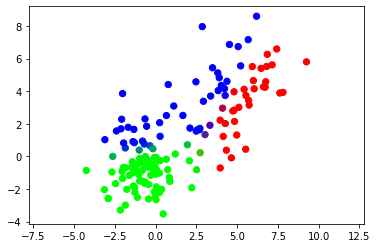

Iteration: 49


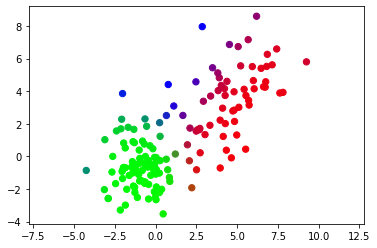

In [173]:
r,gaussian_list,amp_list = GMM(data,k,n=50,rs=np.random.RandomState(2022))

## Result

Result include centroids coordinates:

In [123]:
mean = np.array([g.mean for g in gaussian_list])
cov = np.array([g.cov for g in gaussian_list])
amp = amp_list

In [124]:
for i in range(k):
    print(f"Gaussian{i}:\n Mean={mean[i]},\n Covariance={cov[i]},\n Amplitude={amp[i]}")

Gaussian0:
 Mean=[4.67284762 3.15521889],
 Covariance=[[3.10579686 2.48762413]
 [2.48762413 4.78639543]],
 Amplitude=0.340887729033838
Gaussian1:
 Mean=[-0.96134047 -0.76865958],
 Covariance=[[ 1.10619762 -0.06284493]
 [-0.06284493  1.66971694]],
 Amplitude=0.521986761545122
Gaussian2:
 Mean=[1.9516328  3.24015187],
 Covariance=[[8.08152158 4.5479873 ]
 [4.5479873  6.34250705]],
 Amplitude=0.13712550942104


Displaying Clusters and their centroids.

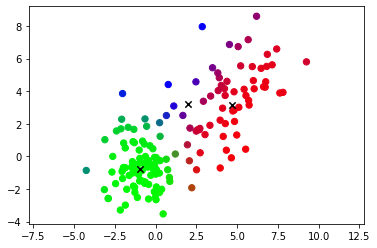

In [174]:
plot_GMM(data,r,mean)

# Comparison of Results

K_Means:

Iteration: 0


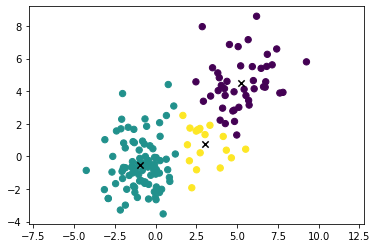

Iteration: 5


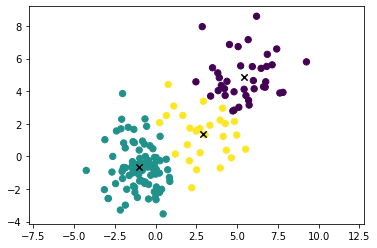

Iteration: 9


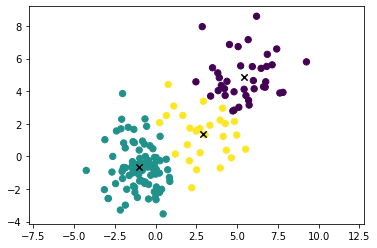

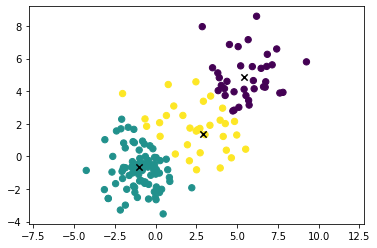

In [185]:
centroids = K_Means(data,k,n=10,rs=np.random.RandomState(0))
plot_K_Means(data,centroids,assignments)

GMM:

Iteration: 0


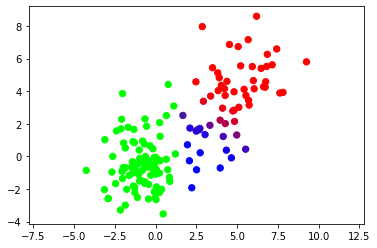

Iteration: 49


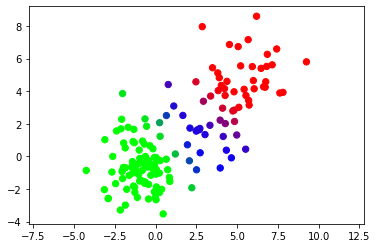

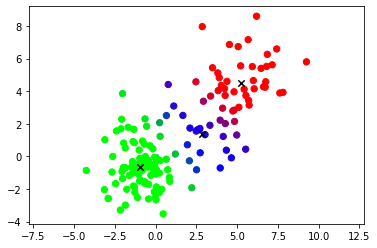

In [186]:
r,gaussian_list,amp_list = GMM(data,k,n=50,rs=np.random.RandomState(0))
mean = np.array([g.mean for g in gaussian_list])
plot_GMM(data,r,mean)

Using the same Random State, we can see that the result is very alike. Comparing to KMeans, GMM result offers some overlaps between clusters.

# Problems, Challenges and Optimizations

## Challenge

**Challenge 1**: Implementing the algorithm formula into python code is a challenge. Translating mathematical language into codes using numpy took me much time and effort. Moreover, though calculating using loops is much easier to construct, numpy offers methods and operations that performs more efficiently than using loops, for example matrix operations. Performing matrix operation took me much time, too.

## Problem

One big problem of the algorithm is that the result changes based on the initial random state. But I have also observed that there are only a few results that will be converged to.

Random Seed:230
Iteration: 0


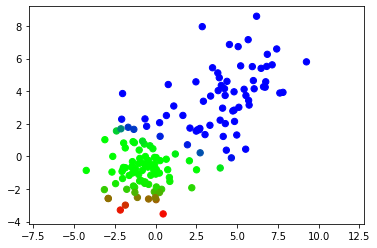

Iteration: 49


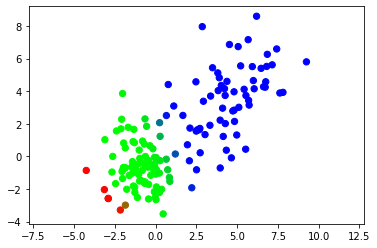

Random Seed:953
Iteration: 0


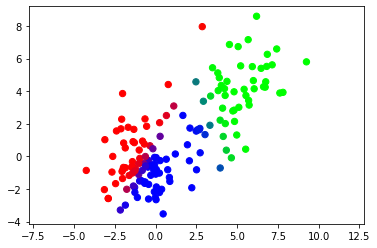

Iteration: 49


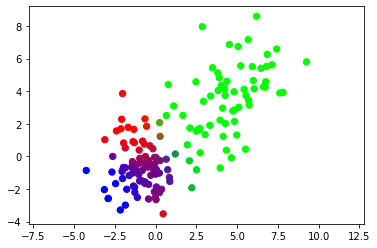

Random Seed:589
Iteration: 0


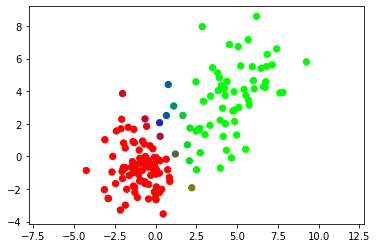

Iteration: 49


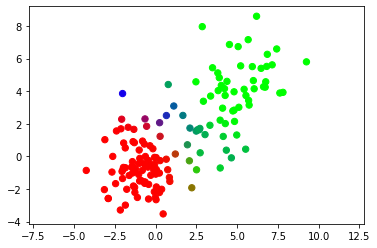

In [177]:
for i in np.random.randint(0,1000,size=3):
    print(f"Random Seed:{i}")
    r,gaussian_list,amp_list = GMM(data,k,n=50,rs=np.random.RandomState(i))

As you can see, we have outputted 3 time with different random states. The result is different every time.

## Optimization

### Log Likelihood

**Log Likelihood** is a calculation of how well the model fits the available points. The higher the value is, the better the fit is. By using this metric, we can visualize the pace of the algorithm (how fast it converges) as well as what trend does it follow (increasing linearly/exponentially/log).


$$
\ell(\theta|\mathbf{x})=\sum_{i=1}^{N} \log\left( \sum_{k=1}^{K} \pi_k N(\boldsymbol{x_i \ | \ \boldsymbol{\mu_k},\boldsymbol{\Sigma_k}})\right)
$$

In [179]:
def llh(data,gaussian_list,amp_list):
    l = np.log(np.sum([amp_list[i]*gaussian_list[i].pdf(data) for i in range(k)]))
    return l
def print_llh(llh_list,n):
    ax = plt.gca()
    ax.set_title('Log-Likelihood')
    ax.plot(np.arange(n),llh_list)
    plt.show()

In [180]:
def GMM_llh(data,k,n=100,rs=np.random.RandomState(0)):
    x_min = np.min(data[:,0])
    x_max = np.max(data[:,0])
    rand_mean_list = rs.randint(x_min,x_max,size=(3,len(data[0])))
    rand_std_list = np.zeros((k,len(data[0]),len(data[0])))
    for dim in range(len(rand_std_list)): np.fill_diagonal(rand_std_list[dim],5)
    gaussian_list = [ss.multivariate_normal(mean=rand_mean_list[i],cov=rand_std_list[i]) for i in range(3)]
    amp_list = [1/k for i in range(k)] # Uniformly divide the amplitude by 1
    log_likelihood = [] # added Loglikelihood record
    for c in range(n):
        r = E_step(gaussian_list,amp_list)
        gaussian_list,amp_list = M_step(r)
        log_likelihood.append(llh(data,gaussian_list,amp_list))  
        #if c==0 or c==n-1:
            #print(f"Iteration: {c}")
            #plot_GMM(data,r)
    return r,log_likelihood

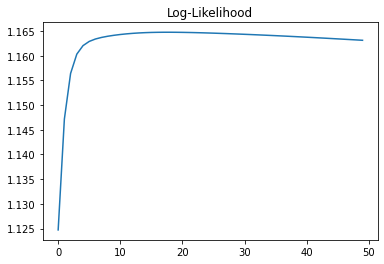

In [181]:
r,log_likelihood = GMM_llh(data,k,n=50,rs=np.random.RandomState(0))
print_llh(log_likelihood,50)

As we can see, the algorithm converges very fast within the first 10 iterations. After that, there is a trend of overfitting.

### Attempted Solution on Encountered Random Result Problem

Although Log-likelihood value differs dramatically among different models, it is comparable on the same model using different parameters. Moreover, I have observed that the max log-likelihood of different random initiating state differs. Since the larger the better, I decide to try 1000 times using different random states, and filter out the best performance seed to generate the best result.

In [183]:
record = {}
for i in np.random.randint(0,2022,size=1000):
    try:
        r,llh_list = GMM_llh(data,k,n=50,rs=np.random.RandomState(i))
    except:
        continue
    record[i] = {"r": r, "llh":llh_list, "max_llh":max(llh_list)}

Best Seed:521 with llh: 1.3157187404908623


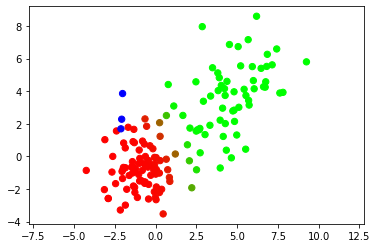

In [184]:
best_seed = sorted(record.items(),key=lambda x: x[1]["max_llh"],reverse=True)[0][0]
print(f"Best Seed:{best_seed} with llh: {record[best_seed]['max_llh']}")
plot_GMM(data,record[best_seed]["r"])

### Step size

My initial guess about the cause of this problem was that the algorithm got stuck on one of the local minimums. As a result, I was hoping that having a bigger step size could help overcoming the obstacle.

In [41]:
#Import r(ic)
def M_step_new(r,step):
    m = np.sum(r,axis = 0) # sum up all r for every c cluster (every column in r)
    amp_list = m/np.sum(m) # sum of mc should be 100%
    mean_list = np.dot(r.T,data)/m.reshape(k,1) # r is nx3, r.T is 3xn, data is nx2, result should be 3x2
    std_list = np.array([(1/m[i])*np.dot(r[:,i]*(data-mean_list[i]).T,(data-mean_list[i])) for i in range(k)])\
    # (data-mean) is still nx2, its T times itself is a 2x2
    std_list = std_list+step
    gaussian_list = [ss.multivariate_normal(mean=mean_list[i],cov=std_list[i]) for i in range(k)]
    return gaussian_list,amp_list

In [44]:
def GMM_new(data,k,n=100,alpha=1e-6,rs=np.random.RandomState(0)):
    step = alpha*np.identity(data.shape[1]) # Adding step size
    
    x_min = np.min(data[:,0])
    x_max = np.max(data[:,0])
    rand_mean_list = rs.randint(x_min,x_max,size=(3,len(data[0])))
    rand_std_list = np.zeros((k,len(data[0]),len(data[0])))
    for dim in range(len(rand_std_list)):
        np.fill_diagonal(rand_std_list[dim],5)
    gaussian_list = [ss.multivariate_normal(mean=rand_mean_list[i],cov=rand_std_list[i]) for i in range(3)]
    amp_list = [1/k for i in range(k)] # Uniformly divide the amplitude by 1
    log_likelihood = [] # added Loglikelihood record
    for c in range(n):
        r = E_step(gaussian_list,amp_list)
        gaussian_list,amp_list = M_step_new(r,step)
        log_likelihood.append(llh(data,gaussian_list,amp_list))
        if c==0 or c==n-1:
            print(f"Iteration: {c}")
            plot_GMM(data,r)
    print_llh(log_likelihood,n)
    return r

Iteration: 0


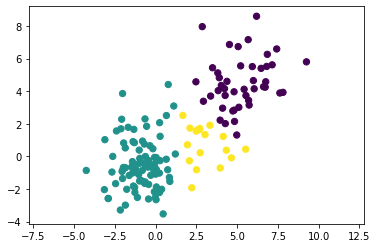

Iteration: 49


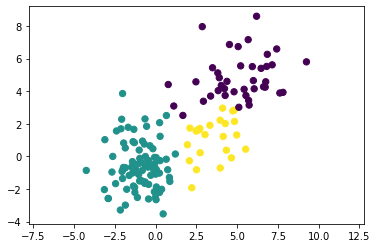

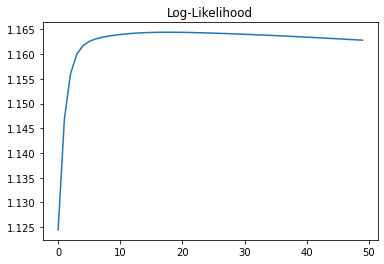

In [46]:
r = GMM_new(data,k,n=50,alpha=1e-3,rs=np.random.RandomState(0))

As you observe, the result is not much affected.

# SKLearn Example

Finally, I tried to implement the library solution. However, it turns out that its result also depends on random initialization.

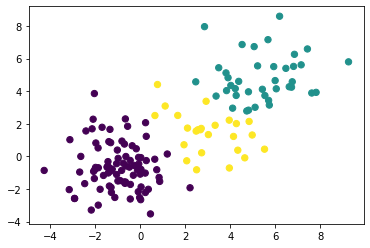

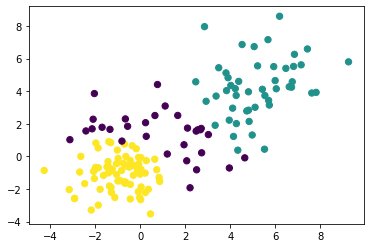

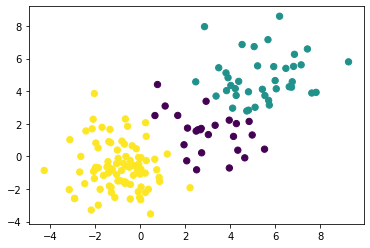

In [48]:
from sklearn import mixture
for i in range(3):
    gmm = mixture.GaussianMixture(n_components=k).fit(data)
    labels = gmm.predict(data)
    plt.scatter(data[:, 0], data[:, 1], c=labels, s=40, cmap='viridis')
    plt.show()